In [1]:
import collections
import random

import tensorflow as tf
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline

import libs.utils as utils

In [2]:
height = 50
width = 50
channel = 3

In [3]:
def random_crop(src, size):
    height = src.shape[0]
    width = src.shape[1]
    
    max_right = width - size[0] -1
    max_bottom = height - size[1] -1
    
    x = random.randint(0, max_right)
    y = random.randint(0, max_bottom)
    
    cropped = src[y: y+size[1], x: x+size[0]]
    
    return cropped

In [4]:
def load_imgs(dir_path):
    name_list = os.listdir(dir_path)
    
    img_list = []
    
    for name in name_list:
        img_path = "{}/{}".format(dir_path, name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        for i in range(50):
            try:
                img_cropped = random_crop(img, (width,height))
                img_list.append(img_cropped)
            except Exception as e:
                print(e)
    return img_list

In [5]:
img_list = load_imgs("./data/urban_hr")

In [40]:
def blur_img_list(img_list):
    result_list =[]
    for img in img_list:
        w = round(width/2)
        h = round(height/2)
        result = cv2.resize(img, (w,h), interpolation = cv2.INTER_CUBIC)
        result = cv2.resize(result, (width,height), interpolation = cv2.INTER_CUBIC)
        result_list.append(result)
    return result_list

In [41]:
X_all = np.array(blur_img_list(img_list))
Y_all = np.array(img_list)

In [42]:
mean_img = np.mean(Y_all, axis=0)
std_img = np.std(Y_all, axis=0)

In [43]:
# data
rand_idx = np.random.permutation(range(len(X_all)))
X_all = X_all[rand_idx]
Y_all = Y_all[rand_idx]


train_ratio = 0.8
valid_ratio = 0.1
test_ratio = 0.1

data_num = len(X_all)
train_data_num = round(data_num * train_ratio)
valid_data_num = round(data_num * valid_ratio)
test_data_num = round(data_num * test_ratio)

X_train = X_all[:train_data_num]
Y_train = Y_all[:train_data_num]
X_valid = X_all[train_data_num:train_data_num+valid_data_num]
Y_valid = Y_all[train_data_num:train_data_num+valid_data_num]
X_test = X_all[train_data_num+valid_data_num:train_data_num+valid_data_num+test_data_num]
Y_test = Y_all[train_data_num+valid_data_num:train_data_num+valid_data_num+test_data_num]

In [44]:
test_img = ((X_valid-mean_img)/std_img)

In [97]:
img_idx = 395

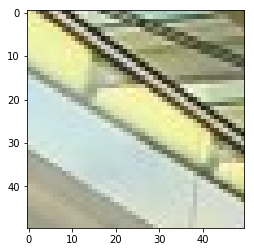

In [98]:
plt.imshow(Y_valid[img_idx])

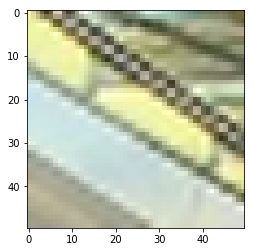

In [99]:
plt.imshow(X_valid[img_idx])

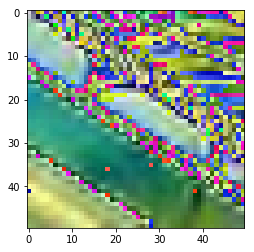

In [100]:
plt.imshow(test_img[img_idx])

In [116]:
tf.reset_default_graph()

In [117]:
def conv2d(X, n_input, n_output, filter_size, activation=None,name=None):
    
    with tf.variable_scope(name):
        W = tf.get_variable(
                    name='W_1',
                    shape=[filter_size[0],filter_size[1],n_input,n_output],
                    initializer=tf.contrib.layers.xavier_initializer_conv2d())

        b = tf.get_variable(
                    name='b_1',
                    shape=[n_output],
                    initializer=tf.constant_initializer(0.))
        
        h = tf.nn.conv2d(X,
                            W, 
                            strides= [1,1,1,1],
                            padding='SAME'
                           )
        if activation != None:
            h = activation(tf.nn.bias_add(h,b))
    
    return h

In [118]:
def build_model():

    
    n_flat = height * width * channel
    X = tf.placeholder(tf.float32, shape=[None, height,width,channel],name='X')
    Y = tf.placeholder(tf.float32, shape=[None, height,width,channel], name='Y')
    
    start_learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    global_step = tf.Variable(0, trainable=False)
    
    layer_info_list = [
        {'name':'conv_1',
                    'n_input':3,
                    'n_output':64,
                    'filter_size':(3,3),
                    'activation':tf.nn.relu},
        {'name':'conv_2',
                    'n_input':64,
                    'n_output':64,
                    'filter_size':(3,3),
                    'activation':tf.nn.relu},
        {'name':'conv_3',
                    'n_input':64,
                    'n_output':64,
                    'filter_size':(3,3),
                    'activation':tf.nn.relu},
        {'name':'conv_4', 
                    'n_input':64,
                    'n_output':64,
                    'filter_size':(3,3),
                    'activation': tf.nn.relu},
        {'name':'conv_5', 
                    'n_input':64,
                    'n_output':3,
                    'filter_size':(3,3),
                    'activation': None},
            ]
    
    current_input = X
    for info in layer_info_list:
        
        current_input = conv2d(X=current_input,
                                   n_input=info['n_input'],
                                   n_output=info['n_output'],
                                   filter_size=info['filter_size'],
                                   activation =info['activation'],
                                   name=info['name'],
                                  )

        
    Y_pred = current_input + X
    
    
    
    Y_pred_flattened = tf.reshape(Y_pred, shape=[-1,n_flat ])
    Y_flattened = tf.reshape(Y, shape=[-1,n_flat])
    
    
    learning_rate = tf.train.exponential_decay(start_learning_rate, global_step,
                                               1000, 0.96, staircase=True)
    
    cost = tf.reduce_mean(tf.reduce_sum(tf.squared_difference(Y_pred_flattened, Y_flattened),axis=1), axis=0)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    return X, Y, Y_pred, cost, optimizer, start_learning_rate

In [293]:
def train(X_train, Y_train, X, Y, Y_pred, cost, optimizer, start_learning_rate,sess = None):

    batch_size = 32
    n_epoch = 200
    
    if sess == None :
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())
        

    for epoch_i in range(n_epoch):
        print("epoh_i : {}".format(epoch_i))
        rand_idx_list = np.random.permutation(range(len(X_train)))
        n_batch = len(rand_idx_list) // batch_size
        for batch_i in range(n_batch):

            rand_idx = rand_idx_list[batch_i*batch_size : (batch_i+1)*batch_size]
            batch_x = X_train[rand_idx]
            batch_y = Y_train[rand_idx]
            sess.run(optimizer, feed_dict={X:(batch_x-mean_img)/std_img, Y: (batch_y-mean_img)/std_img,
                                              start_learning_rate : 0.0000001})

        if epoch_i % 10 == 0 :
            test_img = X_valid[img_idx]
            test_img = np.reshape(test_img, [-1,height, width,channel])
            Y_train_pred = Y_pred.eval(feed_dict={X:(test_img-mean_img)/std_img },session=sess)
            training_cost = sess.run(cost, feed_dict={X:(X_valid[:100]-mean_img)/std_img,Y:(Y_valid[:100]-mean_img)/std_img})

            Y_train_pred = np.reshape(Y_train_pred, [height,width, channel])
            Y_train_pred = Y_train_pred*std_img +mean_img
            Y_train_pred = np.clip(Y_train_pred, 0, 255)

            plt.imshow(Y_train_pred.astype(np.uint8))
            plt.show()
            print("training_cost : {}".format(training_cost))
        
    return sess

In [120]:
X, Y, Y_pred, cost, optimizer,start_learning_rate = build_model()

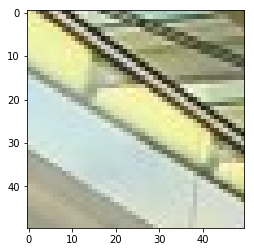

In [130]:
plt.imshow(Y_valid[img_idx])

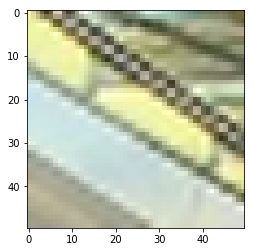

In [131]:
plt.imshow(X_valid[img_idx])

epoh_i : 0


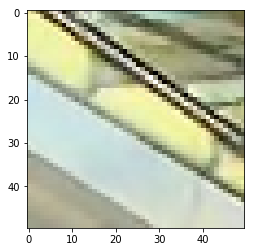

training_cost : 251.24478149414062
epoh_i : 1
epoh_i : 2
epoh_i : 3
epoh_i : 4
epoh_i : 5
epoh_i : 6
epoh_i : 7
epoh_i : 8
epoh_i : 9
epoh_i : 10


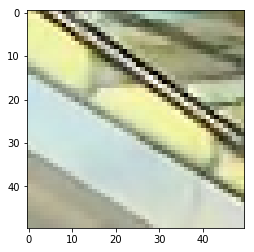

training_cost : 251.28672790527344
epoh_i : 11
epoh_i : 12
epoh_i : 13
epoh_i : 14
epoh_i : 15
epoh_i : 16
epoh_i : 17
epoh_i : 18
epoh_i : 19
epoh_i : 20


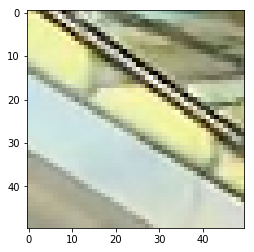

training_cost : 251.291015625
epoh_i : 21
epoh_i : 22
epoh_i : 23
epoh_i : 24
epoh_i : 25
epoh_i : 26
epoh_i : 27
epoh_i : 28
epoh_i : 29
epoh_i : 30


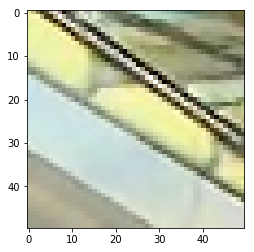

training_cost : 251.29241943359375
epoh_i : 31
epoh_i : 32
epoh_i : 33
epoh_i : 34
epoh_i : 35
epoh_i : 36
epoh_i : 37
epoh_i : 38
epoh_i : 39
epoh_i : 40


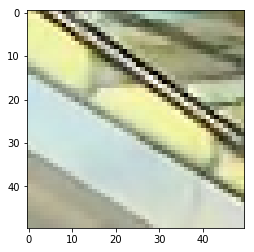

training_cost : 251.29281616210938
epoh_i : 41
epoh_i : 42
epoh_i : 43
epoh_i : 44
epoh_i : 45
epoh_i : 46
epoh_i : 47
epoh_i : 48
epoh_i : 49
epoh_i : 50


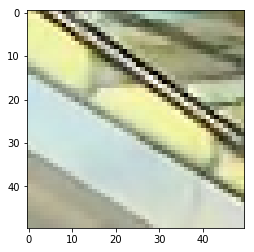

training_cost : 251.29026794433594
epoh_i : 51
epoh_i : 52
epoh_i : 53
epoh_i : 54
epoh_i : 55
epoh_i : 56
epoh_i : 57
epoh_i : 58
epoh_i : 59
epoh_i : 60


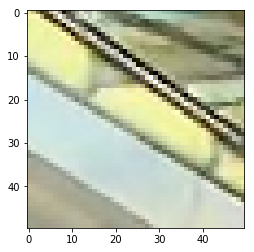

training_cost : 251.29690551757812
epoh_i : 61
epoh_i : 62
epoh_i : 63
epoh_i : 64
epoh_i : 65
epoh_i : 66
epoh_i : 67
epoh_i : 68
epoh_i : 69
epoh_i : 70


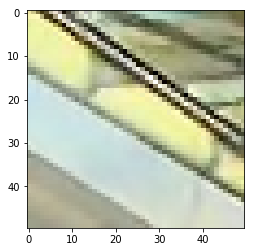

training_cost : 251.2977294921875
epoh_i : 71
epoh_i : 72
epoh_i : 73
epoh_i : 74
epoh_i : 75
epoh_i : 76
epoh_i : 77
epoh_i : 78
epoh_i : 79
epoh_i : 80


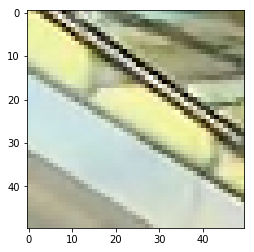

training_cost : 251.29713439941406
epoh_i : 81
epoh_i : 82
epoh_i : 83
epoh_i : 84
epoh_i : 85
epoh_i : 86
epoh_i : 87
epoh_i : 88
epoh_i : 89
epoh_i : 90


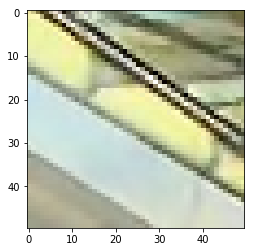

training_cost : 251.29635620117188
epoh_i : 91
epoh_i : 92
epoh_i : 93
epoh_i : 94
epoh_i : 95
epoh_i : 96
epoh_i : 97
epoh_i : 98
epoh_i : 99
epoh_i : 100


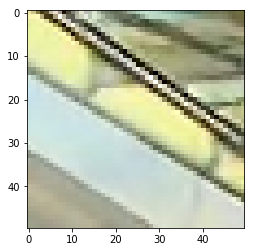

training_cost : 251.29510498046875
epoh_i : 101
epoh_i : 102
epoh_i : 103
epoh_i : 104
epoh_i : 105
epoh_i : 106
epoh_i : 107
epoh_i : 108
epoh_i : 109
epoh_i : 110


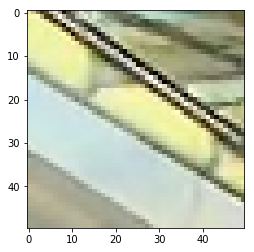

training_cost : 251.29669189453125
epoh_i : 111
epoh_i : 112
epoh_i : 113
epoh_i : 114
epoh_i : 115
epoh_i : 116
epoh_i : 117
epoh_i : 118
epoh_i : 119
epoh_i : 120


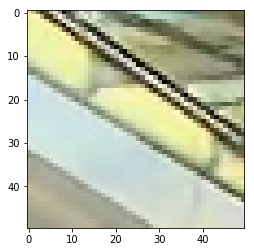

training_cost : 251.29693603515625
epoh_i : 121
epoh_i : 122
epoh_i : 123
epoh_i : 124
epoh_i : 125
epoh_i : 126
epoh_i : 127
epoh_i : 128
epoh_i : 129
epoh_i : 130


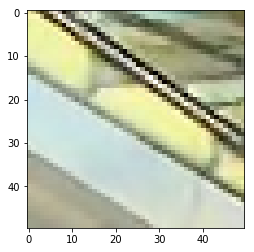

training_cost : 251.297607421875
epoh_i : 131
epoh_i : 132
epoh_i : 133
epoh_i : 134
epoh_i : 135
epoh_i : 136
epoh_i : 137
epoh_i : 138
epoh_i : 139
epoh_i : 140


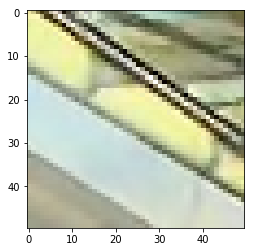

training_cost : 251.2958526611328
epoh_i : 141
epoh_i : 142
epoh_i : 143
epoh_i : 144
epoh_i : 145
epoh_i : 146
epoh_i : 147
epoh_i : 148
epoh_i : 149
epoh_i : 150


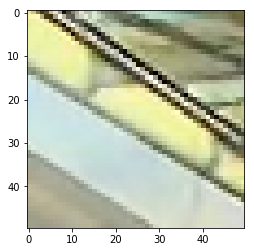

training_cost : 251.29798889160156
epoh_i : 151
epoh_i : 152
epoh_i : 153
epoh_i : 154
epoh_i : 155
epoh_i : 156
epoh_i : 157
epoh_i : 158
epoh_i : 159
epoh_i : 160


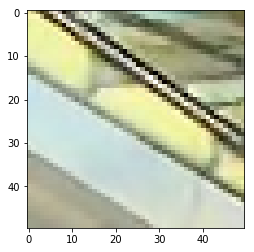

training_cost : 251.302001953125
epoh_i : 161
epoh_i : 162
epoh_i : 163
epoh_i : 164
epoh_i : 165
epoh_i : 166
epoh_i : 167
epoh_i : 168
epoh_i : 169
epoh_i : 170


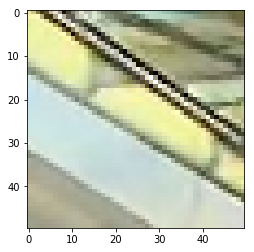

training_cost : 251.30117797851562
epoh_i : 171
epoh_i : 172
epoh_i : 173
epoh_i : 174
epoh_i : 175
epoh_i : 176
epoh_i : 177
epoh_i : 178
epoh_i : 179
epoh_i : 180


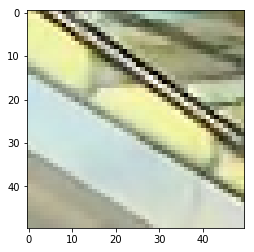

training_cost : 251.3014678955078
epoh_i : 181
epoh_i : 182
epoh_i : 183
epoh_i : 184
epoh_i : 185
epoh_i : 186
epoh_i : 187
epoh_i : 188
epoh_i : 189
epoh_i : 190


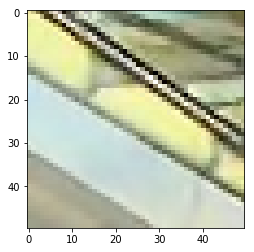

training_cost : 251.304931640625
epoh_i : 191
epoh_i : 192
epoh_i : 193
epoh_i : 194
epoh_i : 195
epoh_i : 196
epoh_i : 197
epoh_i : 198
epoh_i : 199


In [294]:
sess = train(X_train, Y_train, X, Y, Y_pred, cost, optimizer,start_learning_rate, sess)

In [295]:
# save
model_path = "./model/proto2.ckpt"
saver = tf.train.Saver()
save_path = saver.save(sess,model_path)

# Test

In [296]:
test_idx = 35

In [297]:
a = (X_valid[test_idx]-mean_img)/std_img
a = a.reshape([1,height, width, channel])
result = sess.run(Y_pred, feed_dict={X:a})

In [298]:
result = np.reshape(result, [height,width, channel])
result = result*std_img +mean_img
result = np.clip(result, 0, 255)

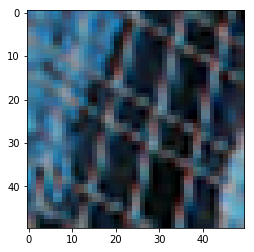

In [299]:
plt.imshow(X_valid[test_idx])

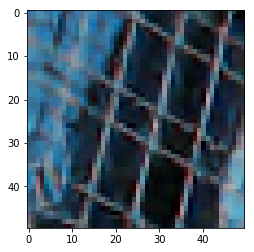

In [300]:
plt.imshow(result.astype(np.uint8))

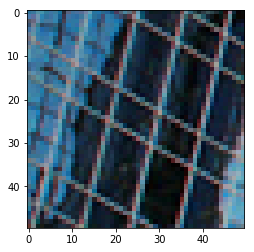

In [301]:
plt.imshow(Y_valid[test_idx])

# Test with celeba

In [389]:
def load_imgs(dir_path):
    name_list = os.listdir(dir_path)
    
    img_list = []
    
    for name in name_list:
        img_path = "{}/{}".format(dir_path, name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        img_list.append(img)
    return img_list

In [390]:
test_img_list = load_imgs("./data/celeba")

In [391]:
test_img = test_img_list[10]

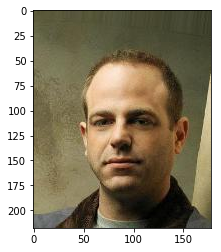

In [392]:
plt.imshow(test_img)

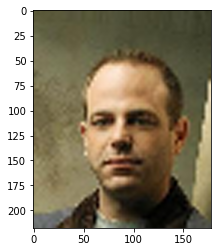

In [393]:
test_img_resized = cv2.resize(test_img, (test_img.shape[1]//3, test_img.shape[0]//3), interpolation = cv2.INTER_CUBIC)
test_img_resized = cv2.resize(test_img_resized, (test_img.shape[1],test_img.shape[0]), interpolation = cv2.INTER_CUBIC)
plt.imshow(test_img_resized)

In [394]:
test_img.shape

(218, 178, 3)

In [395]:
a = test_img[200:250, 150:200]

In [396]:
a.shape

(18, 28, 3)

In [397]:
import math

In [398]:
def divide_img_to_patch(src,size):
    patch_list = []
    
    img_h = src.shape[0]
    img_w = src.shape[1]
    
    
    size_h = size[1]
    size_w = size[0]
    
    
    width_q = math.ceil(img_w / size_w)
    height_q = math.ceil(img_h / size_h)
    
    
    
    background = np.zeros(shape=(height_q*size_h, width_q*size_w,3),dtype=src.dtype)
    background[:img_h, :img_w] = src
    src_with_background = background
    
    shape = (height_q, width_q)
    
    for h_i in range(height_q):
        for w_i in range(width_q):
            patch = src_with_background[h_i*size_h:(h_i+1)*size_h, w_i*size_w : (w_i+1)*size_w]
            patch_list.append(patch)
            
            
    return patch_list, shape

In [399]:
patch_list, shape = divide_img_to_patch(test_img,(width,height))

result_list = []

for patch in patch_list :
    a = (patch-mean_img)/std_img
    a = a.reshape([1,height, width, channel])
    result = sess.run(Y_pred, feed_dict={X:a})
    result = np.reshape(result, [height,width, channel])
    result = result*std_img +mean_img
    result = np.clip(result, 0, 255)
    result = result.astype(np.uint8)
    result_list.append(result)

In [400]:
row_list = []
for row in range(shape[0]):
    col_list = []
    for col in range(shape[1]):
        col_list.append(result_list[row*shape[1]+col])
    row = np.concatenate(col_list,axis=1)
    row_list.append(row)
recon_img = np.concatenate(row_list, axis=0)

In [401]:
recon_img = recon_img[:test_img.shape[0],:test_img.shape[1]]

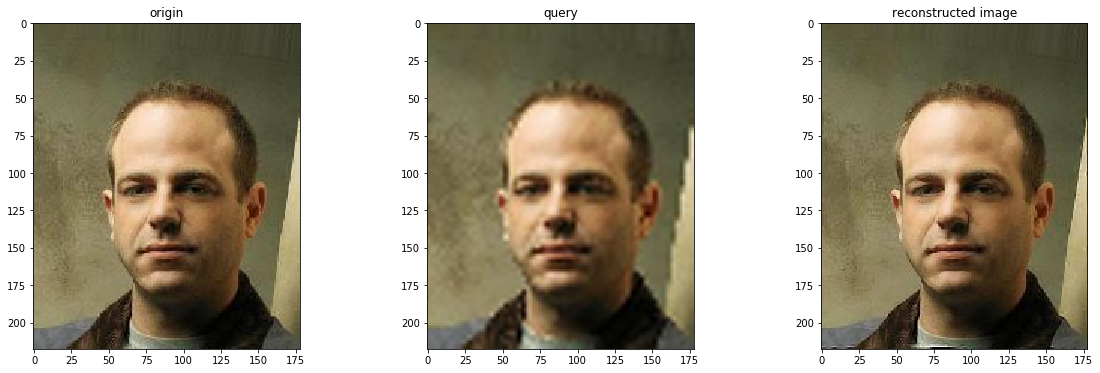

In [402]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].imshow(test_img)
axs[0].set_title("origin")
axs[1].imshow(test_img_resized)
axs[1].set_title("query")
axs[2].imshow(recon_img)
axs[2].set_title("reconstructed image")

In [403]:
result.shape

(50, 50, 3)

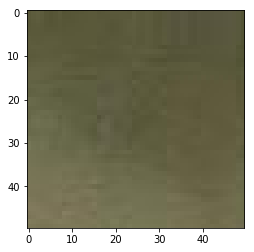

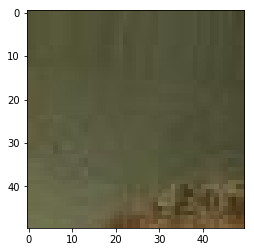

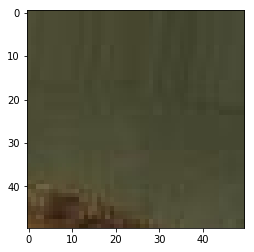

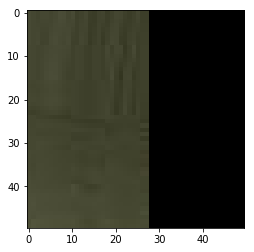

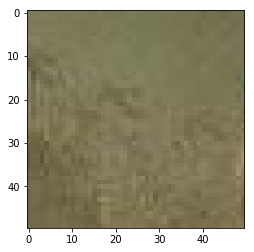

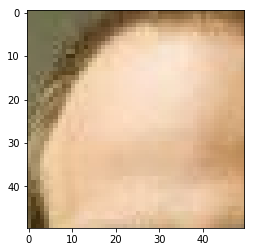

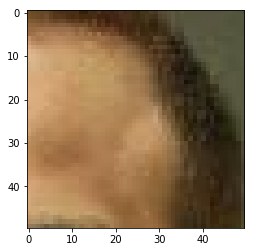

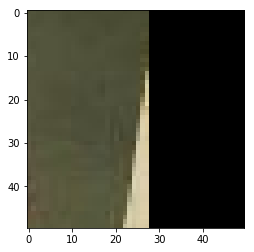

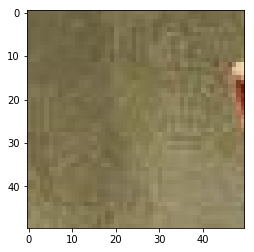

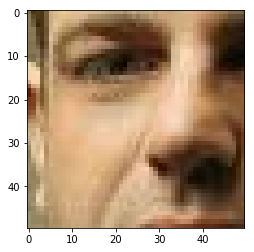

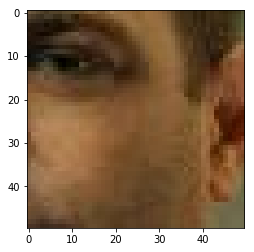

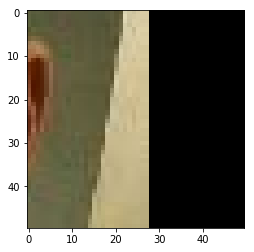

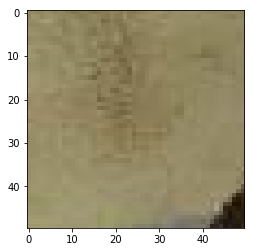

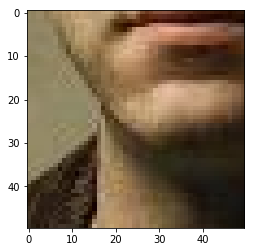

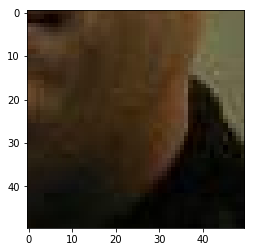

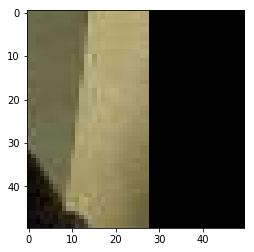

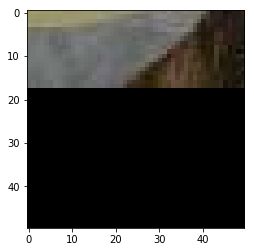

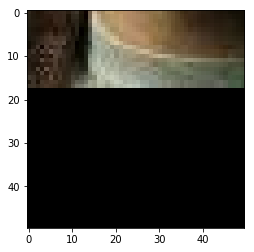

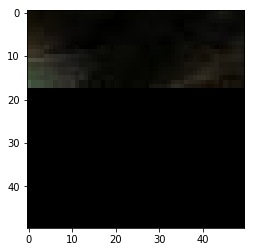

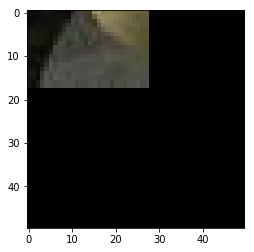

In [404]:
for patch in patch_list :
    a = (patch-mean_img)/std_img
    a = a.reshape([1,height, width, channel])
    result = sess.run(Y_pred, feed_dict={X:a})
    result = np.reshape(result, [height,width, channel])
    result = result*std_img +mean_img
    result = np.clip(result, 0, 255)
    result = result.astype(np.uint8)
    plt.imshow(patch)
    plt.show()

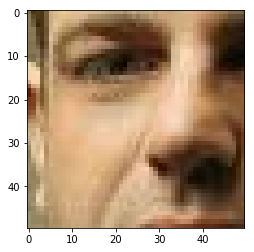

In [405]:
plt.imshow(patch_list[9])

In [ ]:
import

In [406]:
meta = {
    "mean_img": mean_img,
    "std_img": std_img,
    "shape": (50,50,3),
    "min_loss": 251.1
}
meta_path = "./model/meta_data.pickle"
with open(meta_path, "wb") as f:
    pickle.dump(meta, f)

NameError: name 'pickle' is not defined